# Keyword Spotting - On/Off

This tutorial describes how to use the MLTK to develop a machine learning model to detect the keywords:

- __On__
- __Off__

## Quick Links

- [GitHub Source](https://github.com/SiliconLabs/mltk/blob/master/mltk/tutorials/keyword_spotting_on_off.ipynb) - View this tutorial on Github
- [Train in the "Cloud"](https://siliconlabs.github.io/mltk/mltk/tutorials/cloud_training_with_vast_ai.html) - _Vastly_ improve training times by training this model in the "cloud"
- [C++ Example Application](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/audio_classifier.html) - View this tutorial's associated C++ example application
- [Machine Learning Model](https://siliconlabs.github.io/mltk/docs/python_api/models/siliconlabs/keyword_spotting_on_off_v3.html) - View this tutorial's associated machine learning model

## Overview

### Objectives

After completing this tutorial, you will have:
1. A better understanding of how keyword-spotting (KWS) machine learning models work
2. All of the tools needed to develop your own KWS machine learning model
3. A working demo to turn an LED on/off based on the voice commands of your choice 

### Content

This tutorial is divided into the following sections:
1. [Overview of machine learning and keyword-spotting](#machine-learning-and-keyword-spotting-overview)
2. [Dataset selection and preprocessing parameters](#dataset-selection-and-preprocessing-parameters)
3. [Creating the model specification](#model-specification)
4. [Visualizing the audio dataset](#audio-visualization)
5. [Note about model parameters](#model-parameters)
6. [Summarizing the model](#model-visualization)
7. [Visualizing the model graph](#model-visualization)
8. [Profiling the model](#model-profiler)
9. [Training the model](#model-training)
10. [Evaluating the model](#model-evaluation)
11. [Testing the model](#model-testing)
12. [Deploying the model to an embedded device](#deploying-the-model)


### Running this tutorial from the command-line

While this tutorial uses a [Jupyter Notebook](https://jupyter.org), 
the recommended approach is to use your favorite text editor and standard command terminal, no Jupyter Notebook required.  

See the [Standard Python Package Installation](https://siliconlabs.github.io/mltk/docs/installation.html#standard-python-package) guide for more details on how to enable the `mltk` command in your local terminal.

In this mode, when you encounter a `!mltk` command in this tutorial, the command should actually run in your local terminal (excluding the `!`)

## Install MLTK Python Package

Before using the MLTK, it must first be installed.  
See the [Installation Guide](https://siliconlabs.github.io/mltk/docs/installation.html) for more details.

In [ ]:
!pip install --upgrade silabs-mltk

All MLTK modeling operations are accessible via the `mltk` command.  
Run the command `mltk --help` to ensure it is working.  
__NOTE:__ The exclamation point `!` tells the Notebook to run a shell command, it is not required in a [standard terminal](https://siliconlabs.github.io/mltk/docs/installation.html#standard-python-package)

In [1]:
!mltk --help

Usage: mltk [OPTIONS] COMMAND [ARGS]...

  Silicon Labs Machine Learning Toolkit

  This is a Python package with command-line utilities and scripts to aid the
  development of machine learning models for Silicon Lab's embedded platforms.

Options:
  --version  Display the version of this mltk package and exit
  --help     Show this message and exit.

Commands:
  build           MLTK build commands
  classify_audio  Classify keywords/events detected in a microphone's...
  commander       Silab's Commander Utility
  custom          Custom Model Operations
  evaluate        Evaluate a trained ML model
  profile         Profile a model
  quantize        Quantize a model into a .tflite file
  summarize       Generate a summary of a model
  train           Train an ML model
  update_params   Update the parameters of a previously trained model
  utest           Run the all unit tests
  view            View an interactive graph of the given model in a...
  view_audio      View the spectrogram

## Machine Learning and Keyword-Spotting Overview

Before continuing with this tutorial, it is recommended to review the following presentations:  
- [MLTK Overview](https://siliconlabs.github.io/mltk/docs/overview.html) - An overview of the core concepts used by the this tutorial
- [Keyword Spotting Overview](https://siliconlabs.github.io/mltk/docs/audio/keyword_spotting_overview.html) - An overview of how keyword spotting works

## Dataset Selection and Preprocessing Parameters

Before starting the actual tutorial, let's first discuss datasets.

### TL;DR  

1. A _representative_ dataset must be acquired for the trained model to perform well in the real-world
   - Having a representative "unknown" class is critical; detecting the "known" classes is easy; rejecting everything else is hard.
2. The dataset should (typically) be transformed so that the model can efficiently learn the features of the dataset
3. Whatever transformations are used must be identical at training-time on the PC and run-time on the embedded device
4. The size of the dataset can be effectively increased by randomly augmenting it during training (changing the pitch, speed, adding background noise, etc.)

### Acquire a Representative Dataset

The most critical aspect of any machine learning model is the dataset. A _representative_ dataset is necessary to train a robust model.
A model that is trained on a dataset that is too small and/or not representative of what would be seen in the real-world will likely not perform well.

In this tutorial, we want to create a keyword spotting classification machine learning model. This implies the following about the dataset:  
- The dataset must contain audio samples of the keywords we want to detect
- The dataset must be labelled, i.e. each sample in the dataset must have an associated "class", e.g. "on", "off"
- The dataset must be relatively large and representative to account for the variance in spoken language (accents, background noise, etc.) 

For this tutorial, we'll use the [Google Speech Commands v2](https://www.tensorflow.org/datasets/catalog/speech_commands) dataset
(__NOTE:__ This dataset is automatically downloaded in a later step in this tutorial).  
This dataset is effectively a directory of sub-directories, and each sub-directory contains thousands of 1s audio clips.
The name of each sub-directory corresponds to the word being spoken in the audio clip, e.g:

```console
/dataset
/dataset/on
/dataset/on/sample1.wav
/dataset/on/sample2.wav
...
/dataset/off
/dataset/off/sample1.wav
/dataset/off/sample2.wav
...
```

### Synthetically Generated Dataset

The [Google Speech Commands v2](https://www.tensorflow.org/datasets/catalog/speech_commands) is relatively small. The "on" and "off" classes only have about 3k samples.
To create a robust model that works in the real-world, the dataset should have 10k+ samples (or even 100k+).

However, creating a large dataset can be expensive. To help overcome this, we use the [AudioDatasetGenerator](https://siliconlabs.github.io/mltk/docs/python_api/utils/audio_dataset_generator/index.html)
utility that comes with the MLTK. This is a utility that automatically generates audio samples using the Google, Amazon, and Microsoft clouds.
Refer to the [Synthetic Audio Dataset Generation](https://siliconlabs.github.io/mltk/mltk/tutorials/synthetic_audio_dataset_generation.html) tutorial for more details.

With this utility, we generate the [Synthetic On/off Dataset](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/on_off.html) which adds about 15k more samples to our training dataset.

### Creating an "Unknown" Class

Creating a model that can detect the "known" classes (i.e. "on" and "off") is relatively easy.
Creating a model that can also reliably reject everything else is typically a much harder problem. 
For instance, consider that we are making a voice-controlled light switch that turns the lights on and off. In this case, the lights must only change with the keywords "on" and "off". 
The switch must ignore all other sounds. (It would make for a poor user experience if the lights changed while having a conversation next to the switch.) This is why the "unknown" class is critical.
The model should predict the "unknown" class for every other sound that is not a "known" class. 

So to summarize:
- __Known classes__ - The keywords we want to detection (i.e. "on" and "off")
- __Unknown class__ - Every other possible sound that might be heard in the field (silence, other words, random household noises, etc.)

To help create a _representative_ "unknown" class, we use several datasets:

- [ML Commons Keywords](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/ml_commons/keywords.html) - Multilingual Spoken Words Corpus is a large and growing audio dataset of spoken words in 50 languages
- [Environmental Sound Classification](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/background_noise/esc50.html) - Collection of 2k short clips comprising 50 classes of various common sound events

### Dataset Summary

This model was trained using several different datasets:  

- [mltk.datasets.audio.on_off](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/on_off.html) - Synthetically generated keywords: on, off
- [mltk.datasets.audio.speech_commands_v2](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/speech_commands_v2.html) - Human generated keywords: on, off
- [mltk.datasets.audio.mlcommons.ml_commons_keyword](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/ml_commons/keywords.html) - Large collection of keywords, random subset used for *unknown* class
- [mltk.datasets.audio.background_noise.esc50](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/background_noise/esc50.html) - Collection of various noises, random subset used for *unknown* class
- [mltk.datasets.audio.background_noise.ambient](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/background_noise/ambient.html) - Collection of various background noises, mixed into other samples for augmentation
- [mltk.datasets.audio.background_noise.brd2601](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/background_noise/brd2601.html) - "Silence" recorded by BRD2601 microphone, mixed into other samples to make them "sound" like they 
- [mltk.datasets.audio.mit_ir_survey](https://siliconlabs.github.io/mltk/docs/python_api/datasets/audio/mit_ir_survey.html) - Impulse responses that are randomly convolved with the samples. This makes the samples sound if they were recorded in different environments

### Final note about the dataset

The combined datasets meet our requirements:  
- They contain audio samples of the keywords we want to detect ("on", "off")
- The samples are labelled (all "on" samples are in the "on" sub-directory etc.)
- The dataset is representative (the audio clips are taken from many different people saying the same words, _as well as_ randomly audio samples for the "unknown" or "negative" class)

__NOTE:__ For many machine learning applications acquiring a dataset will not be so easy. 
Many times the dataset will suffer from one or more of the following:
- The dataset does not exist - Need to manually collect samples
- The raw samples exist but are not "labeled" - Need to manually group the samples
- The dataset is "dirty" - Bad/corrupt samples, mislabeled samples
- The dataset is not representative - Duplicate/similar samples, not diverse enough to cover the possible range seen in the real-world

__NOTE:__ A clean, representative dataset is one of the best ways to train a robust model.
It is _highly_ recommended to invest the time/energy to create a good dataset!

### Feature Engineering

Along with a representative dataset, we (usually) need to transform the individual samples of the dataset
so that the machine learning model can efficiently learn the "features" of the dataset, and thus make accurate predictions. 
This process is frequently called "feature engineering". One way of describing feature engineering is: 
Use human insight to amplify the signals of the dataset so that a machine can more efficiently learn the patterns in it.

The transform(s) used for feature engineering are highly application-specific.

For this tutorial, we use the common technique of converting the raw audio into a spectrogram (i.e. gray-scale image).
The machine learning model then learns the patterns in the spectrogram images that correspond to the keywords in the audio samples.

### Featuring Engineering on the Edge

An important aspect to keep in mind about the transform(s) chosen for featuring engineering 
is that whatever is done to the dataset samples during training must also be
done on the embedded device at run-time. i.e. The _exact_ algorithms used to generate the
spectrogram on the PC during training _must_ be used on the embedded device at run-time.
Any divergence will cause the embedded model to "see" different samples and likely not perform well (if at all).

For this purpose, the MLTK offers an [Audio Feature Generator](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html) component. 
This component generates spectrograms from raw audio. The algorithms used in this component are accessible via:

- MLTK [Python API](https://siliconlabs.github.io/mltk/docs/python_api/data_preprocessing/audio_feature_generator.html)
- Gecko SDK [firmware component](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html#gecko-sdk-component)

In this way, the _exact_ spectrogram generation algorithms used during training may also be used at
run-time on the embedded device.

Refer to the  [Audio Feature Generator](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html) documentation
and [Audio Visualization](#audio-visualization) section for more details on how the various parameters used to generate the spectrogram may be determined.

### Data Augmentation

A useful technique for expanding the size of a dataset (and hopefully making it more representative) is to apply random augmentations to the training samples.
For instance, audio dataset augmentations might include:
- Increase/decrease speed
- Increase/decrease pitch
- Add random background noises
- Applying an impulse response
- Cropping "known" samples and adding to the "unknown" class

In this way, the model never "sees" the same sample during training which should hopefully make it robust
as it has learned from a larger collection of samples.

#### Random Impulse Response

Another way of making an audio sample sound different is to apply an "impulse response" to it. The impulse response can make the audio sound as if it was captured in a different environment (e.g. in a church, in a field, etc.).

To do this, we randomly apply impulse responses from the [MIT Impulse Response Survey](https://mcdermottlab.mit.edu/Reverb/IR_Survey.html)

#### Random "unknown" samples by cropping "known" samples

On the device, audio is constantly streaming from the microphone. As such, there may be cases where the audio sample is only partially buffered when it is classified by the model. To account for this, the "known" samples are randomly cropped and applied to the "unknown" classes. This way, the model considers partially buffered "known" samples to be "unknown".

## Model Specification

The model specification is a standard Python script containing everything needed to build, train, and evaluate a machine learning model in the MLTK.

Refer to the [Model Specification Guide](https://siliconlabs.github.io/mltk/docs/guides/model_specification.html) for more details about this file.

The completed model specification used for this tutorial may be found on Github: [keyword_spotting_on_off_v3.py](https://github.com/siliconlabs/mltk/blob/master/mltk/models/siliconlabs/keyword_spotting_on_off_v3.py).  

It is recommended to copy & paste [keyword_spotting_on_off_v3.py](https://github.com/siliconlabs/mltk/blob/master/mltk/models/siliconlabs/keyword_spotting_on_off_v3.py) into your local [MLTK Python environment](https://siliconlabs.github.io/mltk/docs/installation.html#standard-python-package)

The following sub-sections provide _code snippets_ from the [keyword_spotting_on_off_v3.py](https://github.com/siliconlabs/mltk/blob/master/mltk/models/siliconlabs/keyword_spotting_on_off_v3.py) model specification script:

### Define Model Object

Near the top of the model specification script, are the lines:

In [3]:
# @mltk_model
class MyModel(
    mltk_core.MltkModel,    # We must inherit the MltkModel class
    mltk_core.TrainMixin,   # We also inherit the TrainMixin since we want to train this model
    mltk_core.DatasetMixin, # We also need the DatasetMixin mixin to provide the relevant dataset properties
    mltk_core.EvaluateClassifierMixin,  # While not required, also inherit EvaluateClassifierMixin to help will generating evaluation stats for our classification model
):
    pass
# Instantiate our custom model object
# The rest of this script simply configures the properties
# of our custom model object
my_model = MyModel()

This defines and instantiates a custom MltkModel object with several model "mixins".  

The custom model object must inherit the [MltkModel](https://siliconlabs.github.io/mltk/docs/python_api/mltk_model/index.html) object.  
Additionally, it inherits:
- [TrainMixin](https://siliconlabs.github.io/mltk/docs/python_api/mltk_model/train_mixin.html) so that we can train the model
- [DatasetMixin](https://siliconlabs.github.io/mltk/docs/python_api/mltk_model/dataset_mixin.html) so that we get additional dataset properties
- [EvaluateClassifierMixin](https://siliconlabs.github.io/mltk/docs/python_api/mltk_model/evaluate_classifier_mixin.html) so that we can evaluate the trained model

The rest of the model specification script configures the various properties of our custom model object.

### Configure the general model settings

In [ ]:
# For better tracking, the version should be incremented any time a non-trivial change is made
# NOTE: The version is optional and not used directly used by the MLTK
my_model.version = 1 
# Provide a brief description about what this model models
# This description goes in the "description" field of the .tflite model file
my_model.description = 'Keyword spotting classifier to detect: "on" and "off"'

### Configure the basic training settings

Refer to the [TrainMixin](https://siliconlabs.github.io/mltk/docs/python_api/mltk_model/train_mixin.html) for more details about each property.

In [4]:
# This specifies the number of times we run the training.
# We just set this to a large value since we're using SteppedLearnRateScheduler
# to control when training completes
my_model.epochs = 9999
# Specify how many samples to pass through the model
# before updating the training gradients.
# Typical values are 10-64
# NOTE: Larger values require more memory and may not fit on your GPU
my_model.batch_size = 100

### Configure the training callbacks

Refer to the [TrainMixin](https://siliconlabs.github.io/mltk/docs/python_api/mltk_model/train_mixin.html) for more details about each property.

In [5]:
# The MLTK enables the tf.keras.callbacks.ModelCheckpoint by default.
my_model.checkpoint['monitor'] =  'val_accuracy'


# We use a custom learn rate schedule that is defined in:
# https://github.com/google-research/google-research/tree/master/kws_streaming
my_model.train_callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    SteppedLearnRateScheduler([
        (100,   .001),
        (100,   .002),
        (100,   .003),
        (100,   .004),
        (10000, .005),
        (10000, .002),
        (5000, .0005),
        (5000, 1e-5),
        (5000,  1e-6),
        (5000,  1e-7),
    ] )
]

### Configure the TF-Lite Converter settings

The [Tensorflow-Lite Converter](https://www.tensorflow.org/lite/convert) is used to "quantize" the model.  
The quantized model is what is eventually programmed to the embedded device.

Refer to the [Model Quantization Guide](https://siliconlabs.github.io/mltk/docs/guides/model_quantization.html) for more details.

In [6]:
# These are the settings used to quantize the model
# We want all the internal ops as well as
# model input/output to be int8
my_model.tflite_converter['optimizations'] = [tf.lite.Optimize.DEFAULT]
my_model.tflite_converter['supported_ops'] = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
my_model.tflite_converter['inference_input_type'] = np.int8
my_model.tflite_converter['inference_output_type'] = np.int8
# Automatically generate a representative dataset from the validation data
my_model.tflite_converter['representative_dataset'] = 'generate'

### Define the model architecture

The model is based on the [Temporal efficient neural network (TENet)](https://arxiv.org/pdf/2010.09960.pdf) model architecture.  
> A network for processing spectrogram data using temporal and depthwise convolutions. The network treats the [T, F] spectrogram as a timeseries shaped [T, 1, F].

This model was chosen because it has good accuracy for audio datasets and executes efficiently on the EFR32xG24 MCU.

More details at [mltk.models.shared.tenet.TENet](https://siliconlabs.github.io/mltk/docs/python_api/models/common_models.html#tenet)

In [ ]:
def my_model_builder(model: MyModel) -> tf.keras.Model:
    """Build the Keras model
    """
    input_shape = model.input_shape
    # NOTE: This model requires the input shape: <time, 1, features>
    #       while the embedded device expects: <time, features, 1>
    #       Since the <time> axis is still row-major, we can swap the <features> with 1 without issue
    time_size, feature_size, _ = input_shape
    input_shape = (time_size, 1, feature_size)

    keras_model = tenet.TENet12(
        input_shape=input_shape,
        classes=model.n_classes,
        channels=50,
        blocks=5,
    )

    keras_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-8),
        metrics= ['accuracy']
    )

    return keras_model

my_model.build_model_function = my_model_builder
# TENet uses a custom layer, be sure to add it to the keras_custom_objects
# so that we can load the corresponding .h5 model file
my_model.keras_custom_objects['MultiScaleTemporalConvolution'] = tenet.MultiScaleTemporalConvolution

### Audio Feature Generator Settings

This model uses the following [Audio Feature Generator](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html) settings:

In [ ]:
from mltk.core.preprocess.audio.audio_feature_generator import AudioFeatureGeneratorSettings

frontend_settings = AudioFeatureGeneratorSettings()

frontend_settings.sample_rate_hz = 16000
frontend_settings.sample_length_ms = 1000                       # A 1s buffer should be enough to capture the keywords
frontend_settings.window_size_ms = 30
frontend_settings.window_step_ms = 10
frontend_settings.filterbank_n_channels = 104                   # We want this value to be as large as possible
                                                                # while still allowing for the ML model to execute efficiently on the hardware
frontend_settings.filterbank_upper_band_limit = 7500.0
frontend_settings.filterbank_lower_band_limit = 125.0           # The dev board mic seems to have a lot of noise at lower frequencies

frontend_settings.noise_reduction_enable = True                 # Enable the noise reduction block to help ignore background noise in the field
frontend_settings.noise_reduction_smoothing_bits = 10
frontend_settings.noise_reduction_even_smoothing =  0.025
frontend_settings.noise_reduction_odd_smoothing = 0.06
frontend_settings.noise_reduction_min_signal_remaining = 0.40   # This value is fairly large (which makes the background noise reduction small)
                                                                # But it has been found to still give good results
                                                                # i.e. There is still some background noise reduction,
                                                                # but the actual signal is still (mostly) untouched

frontend_settings.dc_notch_filter_enable = True                 # Enable the DC notch filter, to help remove the DC signal from the dev board's mic
frontend_settings.dc_notch_filter_coefficient = 0.95

frontend_settings.quantize_dynamic_scale_enable = True          # Enable dynamic quantization, this dynamically converts the uint16 spectrogram to int8
frontend_settings.quantize_dynamic_scale_range_db = 40.0

# Add the Audio Feature generator settings to the model parameters
# This way, they are included in the generated .tflite model file
# See https://siliconlabs.github.io/mltk/docs/guides/model_parameters.html
my_model.model_parameters.update(frontend_settings)

This uses a 16kHz sample rate which was found to give better performance at the expense of more RAM.

```python
frontend_settings.sample_rate_hz = 16000
```

To help reduce the model computational complexity, only a 1000ms sample length is used. 

```python
frontend_settings.sample_length_ms = 1000
```

The idea here is that it only takes at most ~1000ms to say any of the keywords (i.e. the audio buffer needs to be large enough to hold the entire keyword but no larger). 

This model uses a window size of 30ms and a step of 10ms.

```python
frontend_settings.window_size_ms = 30
frontend_settings.window_step_ms = 10
```

These values were found experimentally using the [Audio Visualizer Utility](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html#audio-visualizer-utility).

104 frequency bins are used to generate the spectrogram:

```python
frontend_settings.filterbank_n_channels = 104
```

Increasing this value improves the resolution of spectrogram at the cost of model computational complexity (i.e. inference latency).

The noise reduction block is enabled but uses a fairly large `min_signal_remaining`:
```python
frontend_settings.noise_reduction_enable = True
frontend_settings.noise_reduction_smoothing_bits = 10
frontend_settings.noise_reduction_even_smoothing =  0.025
frontend_settings.noise_reduction_odd_smoothing = 0.06
frontend_settings.noise_reduction_min_signal_remaining = 0.40
```

This helps to reduce background noise in the field.  
__NOTE:__ We also add padding to the audio samples during training to "warm up" the noise reduction block when generating the spectrogram using the 
[Audio Feature Generator](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html). See the `audio_pipeline_with_augmentations()`
function in [keyword_spotting_on_off_v3.py](https://siliconlabs.github.io/mltk/docs/python_api/models/siliconlabs/keyword_spotting_on_off_v3.html#model-specification) for more details.



The DC notch filter was enabled to help remove the DC component from the development board's microphone:
```python
frontend_settings.dc_notch_filter_enable = True # Enable the DC notch filter
frontend_settings.dc_notch_filter_coefficient = 0.95
```

Dynamic quantization was enabled to convert the generated spectrogram from uint16 to int8

```python
frontend_settings.quantize_dynamic_scale_enable = True # Enable dynamic quantization
frontend_settings.quantize_dynamic_scale_range_db = 40.0
```

### Configure the keywords to detect

This is likely the most interesting part of the model specification script. Here, we define which keywords we want our model to detect.  
For this tutorial, we want to detect `on` and `off`, however,
you may modify this as necessary for your application. Be sure to generate a new [Synthetic Dataset](https://siliconlabs.github.io/mltk/mltk/tutorials/synthetic_audio_dataset_generation.html) with the desired keywords.

In [ ]:
# Add the keywords plus a _unknown_ meta class
my_model.classes = ['on', 'off', '_unknown_']

### Data Pipeline

Refer to the `audio_pipeline_with_augmentations()`
function in [keyword_spotting_on_off_v3.py](https://siliconlabs.github.io/mltk/docs/python_api/models/siliconlabs/keyword_spotting_on_off_v3.html#model-specification) for the full data pipeline used by this model.

This pipeline is illustrated as follows:  
![](https://github.com/SiliconLabs/mltk/raw/master/docs/img/keyword_spotting_on_off_v3_data_pipeline.png)

## Audio Visualization

__NOTE:__ This section is __experimental__ and is optional for the rest of this tutorial.
You may safely skip to the next section.

Before training the model, it is important that the generated spectrogram has enough detail from which the ML model can learn (i.e. "feature engineering"). 
The [AudioFeatureGenerator](https://siliconlabs.github.io/mltk/docs/python_api/data_preprocessing/audio_feature_generator.html) has numerous [settings](https://siliconlabs.github.io/mltk/docs/python_api/data_preprocessing/audio_feature_generator_settings.html) to control how the spectrogram is generated.

For this purpose, the MLTK features an experimental command: `view_audio` which allows for visualizing a generated spectrogram in real-time as the various parameters are adjusted via GUI.
It also allows for adjusting the various augmentation parameters and listening to the audio playback.

See the [Audio Feature Generator](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html) guide for more details.

__NOTE:__ Internally, this command uses [wxPython](https://www.wxpython.org) and _must_ run locally. It will not work on a remote server (e.g. Colab).

In [2]:
# Invoke the view_audio command from a LOCAL terminal
# NOTE: Change this command to use
#      "my_keyword_spotting_on_off" or whatever you called your model
!mltk view_audio keyword_spotting_on_off_v3

After running this command and playing with the GUI, you should have a better idea of what settings to use for the AudioFeatureGenerator and data augmentation parameters.

__NOTE:__ Care should be given when selecting the spectrogram size. e.g. The dimensions given in the upper-left:

![Visualizer Dimensions](https://siliconlabs.github.io/mltk/_static/images/visualizer_dimensions.png)

A larger spectrogram means a larger model input which ultimately means more processing that is required by the embedded device at run-time.

See the [Model Optimization Tutorial](https://siliconlabs.github.io/mltk/mltk/tutorials/model_optimization.html) for more details.

## Model Parameters

As stated in the [Feature Engineering on the Edge](#featuring-engineering-on-the-edge) section, it is extremely important that whatever transforms are done to the dataset during training are also done at run-time on the embedded device.

To help with this, the MLTK allows for embedding parameters into the generated `.tflite` model file.

Refer to the [Model Parameters Guide](https://siliconlabs.github.io/mltk/docs/guides/model_parameters.html) for more details about how this works.

This is useful for this tutorial as the MLTK will automatically embed all of the [AudioFeatureGeneratorSettings](https://siliconlabs.github.io/mltk/docs/python_api/data_preprocessing/audio_feature_generator.html#audiofeaturegenerator-settings) into the generated `.tflite` model file.
Later, the Gecko SDK will read the settings from the `.tflite` model file when generating the project. 
In this way, the [AudioFeatureGenerator](https://siliconlabs.github.io/mltk/docs/audio/audio_feature_generator.html) that runs on the embedded device will use the _exact_ same settings.

__NOTE:__ The `mltk summarize --tflite` command prints all the parameters that are embedded into the `.tflite` model file, including the AudioFeatureGenerator settings.

## Model Summary

With the model specification complete, it is sometimes useful to generate a summary of the model before we spend the time to train it.  
This can be done using the `summarize` command.

If you're using a local terminal, navigate to the same directory are your model specification script, e.g. `my_keyword_spotting_on_off_v3.py` and modify the commands to use `my_keyword_spotting_on_off_v3` or whatever you called your model.

__NOTE:__ Since we have not trained our model yet, we must add the `--build` option to the command.  
Once the model is trained, this option is not required.

In [7]:
# Summarize the Keras Model
# This is the non-quantized model used for training
# NOTE: Running this the first time may take awhile since the audio dataset needs to be downloaded
!mltk summarize keyword_spotting_on_off_v3 --build

Model: "TENet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 98, 1, 104)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 98, 1, 50)    15650       ['input_1[0][0]']                
                                                                                                  
 pointwise_expand_conv-0 (Conv2  (None, 98, 1, 150)  7500        ['conv2d[0][0]']                 
 D)                                                                                               
                                                                                              

In [8]:
# Summarize the TF-Lite Model
# This is the quantized model that eventually goes on the embedded device
!mltk summarize keyword_spotting_on_off_v3 --tflite --build

+-------+-------------------+-----------------+-----------------+------------------------------------------------------+
| Index | OpCode            | Input(s)        | Output(s)       | Config                                               |
+-------+-------------------+-----------------+-----------------+------------------------------------------------------+
| 0     | conv_2d           | 98x1x104 (int8) | 98x1x50 (int8)  | Padding:Same stride:1x1 activation:None              |
|       |                   | 3x1x104 (int8)  |                 |                                                      |
|       |                   | 50 (int32)      |                 |                                                      |
| 1     | conv_2d           | 98x1x50 (int8)  | 98x1x150 (int8) | Padding:Valid stride:1x1 activation:Relu             |
|       |                   | 1x1x50 (int8)   |                 |                                                      |
|       |                   | 15

## Model Visualization

The MLTK also allows for visualizing the model in an interactive webpage.

This is done using the `view` command.
Refer to the [Model Visualization Guide](https://siliconlabs.github.io/mltk/docs/guides/model_visualizer.html) for more details on how this works.

__NOTES:__  
- This will open a new tab to your web-browser
- You must click the opened webpage's 'Accept' button the first time it runs (and possibly re-run the command)
- Since we have not trained our model yet, we must add the `--build` option to the command. This is not required once the model is trained.
- This command must run locally, it will not work from a remote terminal/notebook 

### Visualize Keras model

By default, the `view` command will visualize the [KerasModel](https://siliconlabs.github.io/mltk/docs/python_api/keras_model.html), the model used for training (file extension `.h5`).

In [ ]:
# This will open a new tab in your web browser
# Be sure the click the 'Accept' button in the opened webpage
# (you may need to re-run this command after doing so)
!mltk view keyword_spotting_on_off_v3 --build

### Visualize TF-Lite model

Alternatively, the `--tflite` flag can be used to view the [TfliteModel](https://siliconlabs.github.io/mltk/docs/python_api/tflite_model/index.html), the quantized model that is programmed to the embedded device (file extension `.tflite`).

Note that the structure of the Keras and TfLite models are similar, but the TfLite model is a bit more simple. This is because the [TF-Lite Converter](https://www.tensorflow.org/lite/convert) optimized the model by merging/fusing as many layers as possible.

In [ ]:
# This will open a new tab in your web browser
# Be sure the click the 'Accept' button in the opened webpage
# (you may need to re-run this command after doing so)
!mltk view keyword_spotting_on_off_v3 --tflite --build

## Model Profiler

Before spending the time and energy to train the model, it may be useful to profile the model to determine how efficiently it may run on the embedded device.
If it's determined that the model does not fit within the time or memory constraints, then the model layout should be adjusted, the model input size should be reduced, and/or a different model should be selected.

For this reason, th MLTK features a model profiler. Refer to the [Model Profiler Guide](https://siliconlabs.github.io/mltk/docs/guides/model_profiler.html) for more details.

__NOTE:__ The following examples use the `--build` flag since the model has not been trained yet. Once the model is trained this flag is no longer needed.

### Profile in simulator

The following command will profile our model in the MVP hardware simulator and return estimates about the time and energy the model might require on the embedded device. 

__NOTES:__  
- An embedded device does not needed to be locally connected to run this command.
- Remove the `--accelerator MVP` option if you are targeting a device that does not have an MVP hardware accelerator.

In [11]:
!mltk profile keyword_spotting_on_off_v3 --accelerator MVP --build

HINT: Add the --estimates option to generate energy and CPU cycle estimates
Profiling model in simulator ...

Profiling Summary
Name: keyword_spotting_on_off_v3
Accelerator: MVP
Input Shape: 1x98x1x104
Input Data Type: int8
Output Shape: 1x3
Output Data Type: int8
Flash, Model File Size (bytes): 608.2k
RAM, Runtime Memory Size (bytes): 86.6k
Operation Count: 18.2M
Multiply-Accumulate Count: 8.9M
Layer Count: 90
Unsupported Layer Count: 0
Accelerator Cycle Count: 5.5M

Model Layers
+-------+-------------------+--------+--------+------------+--------------------------+--------------+------------------------------------------------------+
| Index | OpCode            | # Ops  | # MACs | Acc Cycles | Input Shape              | Output Shape | Options                                              |
+-------+-------------------+--------+--------+------------+--------------------------+--------------+------------------------------------------------------+
| 0     | conv_2d           | 3.1M   | 1

### Profile on physical device

Alternatively, if we have a device locally connected, we can directly profile on that instead. This is useful as the returned profiling numbers are "real", they are not estimated as they would be in the simulator case. 

To profile on a physical device, simply added the `--device` command flag.

__NOTES:__  
- An embedded device must be locally connected to run this command.
- Remove the `--accelerator MVP` option if you are targeting a device that does not have an MVP hardware accelerator.

In [12]:
!mltk profile keyword_spotting_on_off_v3  --device --accelerator MVP --build

Programming ML model to device ...

Initializing  0% |            | ?B/s
Comparing:  23% | ██▎        | 128kB/s
Comparing:  45% | ████▌      | 115kB/s
Comparing:  68% | ██████▊    | 112kB/s
Comparing:  90% | █████████  | 110kB/s
Comparing: 100% | █████████▉ | 87.4kB/s
Comparing: 100% | ██████████ | 71.1kB/s
Comparing: 100% | ██████████ | 48.5kB/s

Initializing  0% |            | ?B/s
Comparing:  21% | ██▏        | 136kB/s
Comparing:  43% | ████▎      | 117kB/s
Comparing:  64% | ██████▍    | 113kB/s
Comparing:  85% | ████████▌  | 111kB/s
Comparing: 100% | █████████▉ | 97.6kB/s
Comparing: 100% | ██████████ | 71.8kB/s
Comparing: 100% | ██████████ | 49.1kB/s
Profiling ML model on device ...

Profiling Summary
Name: keyword_spotting_on_off_v3
Accelerator: MVP
Input Shape: 1x98x1x104
Input Data Type: int8
Output Shape: 1x3
Output Data Type: int8
Flash, Model File Size (bytes): 608.2k
RAM, Runtime Memory Size (bytes): 84.5k
Operation Count: 18.2M
Multiply-Accumulate Count: 8.9M
Layer Count: 9

### Note about CPU utilization

An important metric the model profiler provides when using the MVP hardware accelerator is `CPU Utilization`.
This gives an indication of how much CPU is required to run the machine learning model.

If no hardware accelerator is used, then the CPU utilization is 100% as 100% of the machine learning model's calculations are executed on the CPU.
With the hardware accelerator, many of the model's calculations can be offloaded to the accelerator freeing the CPU to do other tasks.

The additional CPU cycles the hardware accelerator provides can be a major benefit, especially when other tasks such as real-time audio processing are required.

## Model Training

Now that we have our model fully specified and it fits within the constraints of the embedded device, we can train the model.

The basic flow for model training is:
1. Invoke the `train` command
2. Tensorflow trains the model
3. A [Model Archive](https://siliconlabs.github.io/mltk/docs/guides/model_archive.html) containing the trained model is generated in the same directory as the model specification script 

Refer to the [Model Training Guide](https://siliconlabs.github.io/mltk/docs/guides/model_training.html) for more details about this process.

### Train as a "dry run"

Before fully training the model, sometimes it is useful to train the model as a "dry run" to ensure the end-to-end training process works. Here, the model is trained for a few epochs on a subset of the dataset.

To train as a dry run, append `-test` to the model name.  
At the end of training, a [Model Archive](https://siliconlabs.github.io/mltk/docs/guides/model_archive.html) with `-test` appended to the archive name is generated in the same directory as the model specification script. 

In [13]:
# Train as a dry run by appending "-test" to the model name
!mltk train keyword_spotting_on_off_v3-test

Enabling test mode



*******************************************************************************

This could mean that the driver or CUDA libraries are not properly installed,
or that your installed GPU driver does not match the Tensorflow version.

Refer to the Tensorflow GPU installation guide here:
https://www.tensorflow.org/install/gpu
https://www.tensorflow.org/install/source#gpu

Alternatively, you can disable the GPU by defining the environment variable: CUDA_VISIBLE_DEVICES=-1
.e.g.:
set CUDA_VISIBLE_DEVICES=-1

*******************************************************************************

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
training is using 8 subprocesses
validation is using 8 subprocesses
Model: "TENet"
__________________________________________________________________________________________________
 Laye

### Training locally

One option for training your model is to run the `train` command in your local terminal.  
Most of the models used by embedded devices are small enough that this is a feasible option.  
Never the less, this is a very CPU intensive operation. Many times it's best to issue the `train` command and let it run over night.

See the [Note about training time](#note-about-training-time) section below for more details.

__NOTE:__ Training a model from scratch can be very time-consuming. See the [Transfer Learning Tutorial](https://siliconlabs.github.io/mltk/mltk/tutorials/keyword_spotting_with_transfer_learning.html) for how to speed this process up.

In [ ]:
# Be sure to replace "keyword_spotting_on_off_v3"
# with the name of your model
# WARNING: This command may take several hours
!mltk train keyword_spotting_on_off_v3

### Train in cloud

Alternatively, you can _vastly_ improve the model training time by training this model in the "cloud".  
See the tutorial: [Cloud Training with vast.ai](https://siliconlabs.github.io/mltk/mltk/tutorials/cloud_training_with_vast_ai.html) for more details.

### Note about training time

__TL;DR:__ Improve training time by using a PC/cloud VM with lots of CPU cores (4-16)

Models intended for embedded devices are typically "small". Thus, while one or more powerful GPUs will certainly improve training times, there is an upper limit to their benefit. Many times, the bottleneck during training comes from the data preprocessing which is usually done on the CPU. i.e. The GPU(s) train the model faster than the CPU(s) can generate the next round of training data.

For this reason, it is usually beneficial to use a PC/cloud VM with multiple cores. This way, multiple CPUs can generate training data in parallel while the GPU is always fed with more training data.

The MLTK comes with the [mltk.core.preprocess.utils.tf_dataset.parallel_process()](https://siliconlabs.github.io/mltk/docs/python_api/data_preprocessing/tf_dataset.html#mltk.core.preprocess.utils.tf_dataset.parallel_process) API,  that generates training data by spawning multiple [processes](https://docs.python.org/3.7/library/multiprocessing.html). This allows for multiple cores to generate training data simultaneously.

## Model Evaluation

With our model trained, we can now evaluate it to see how accurate it is.

The basic idea behind model evaluation is to send test samples (i.e. new, unknown samples the model was _not_ trained with) through the model, and compare the model's predictions versus the expected values. If all the model predictions match the expected values then the model is 100% accurate, and every wrong prediction decreases the model accuracy, e.g.:

![Model Accuracy](https://bit.ly/3w9xQXV)  

Assuming the test samples are _representative_ then the model accuracy should indicate how well it will perform in the real-world.

Model evaluation is done using the `evaluate` MLTK command. Along with accuracy, the `evaluate` command generates other statistics such as [ROC-AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [Precision & Recall](https://en.wikipedia.org/wiki/Precision_and_recall).  
Refer to the [Model Evaluation Guide](https://siliconlabs.github.io/mltk/docs/guides/model_evaluation.html) for more details about using the MLTK for model evaluation.

### Command

To evaluate the newly trained model, issue the following command:

__NOTE:__ Be sure to replace `keyword_spotting_on_off_v3` with the name of your model.

In [ ]:
# Run the model evaluation command
!mltk evaluate keyword_spotting_on_off_v3 --tflite --show

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
validation is using 8 subprocesses
+-------+-------------------+-----------------+-----------------+------------------------------------------------------+
| Index | OpCode            | Input(s)        | Output(s)       | Config                                               |
+-------+-------------------+-----------------+-----------------+------------------------------------------------------+
| 0     | conv_2d           | 98x1x104 (int8) | 98x1x50 (int8)  | Padding:Same stride:1x1 activation:None              |
|       |                   | 3x1x104 (int8)  |                 |                                                      |
|       |                   | 50 (int32)      |                 |                                                      |
| 1     | conv_2d           | 98x1x50 

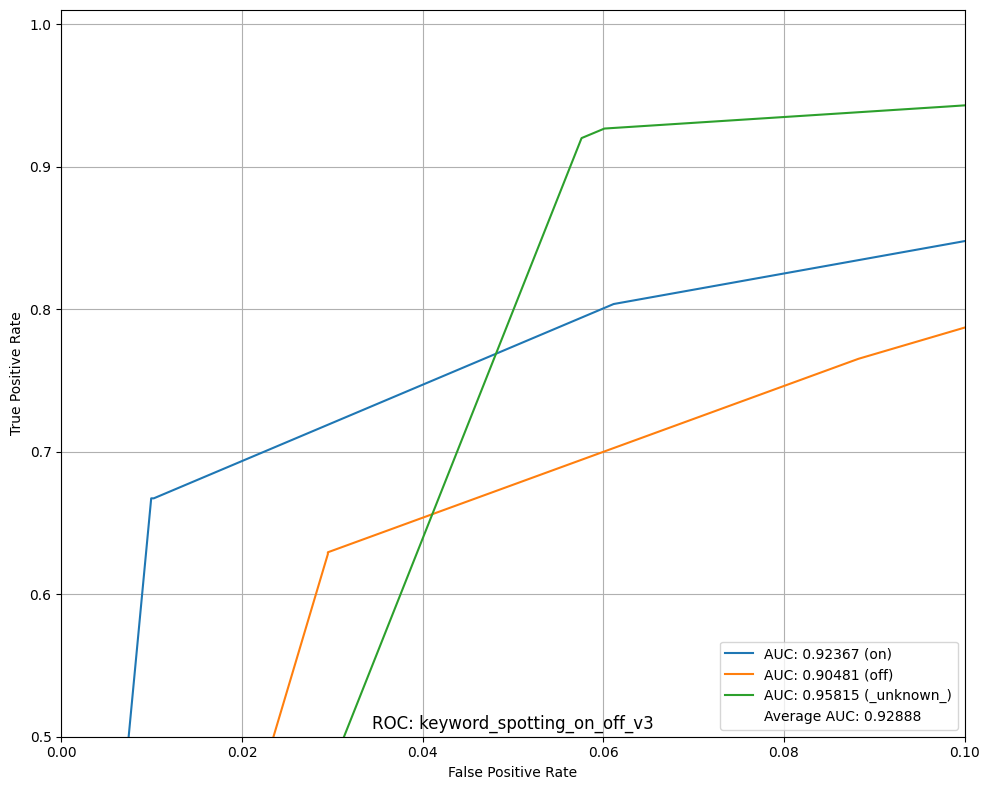

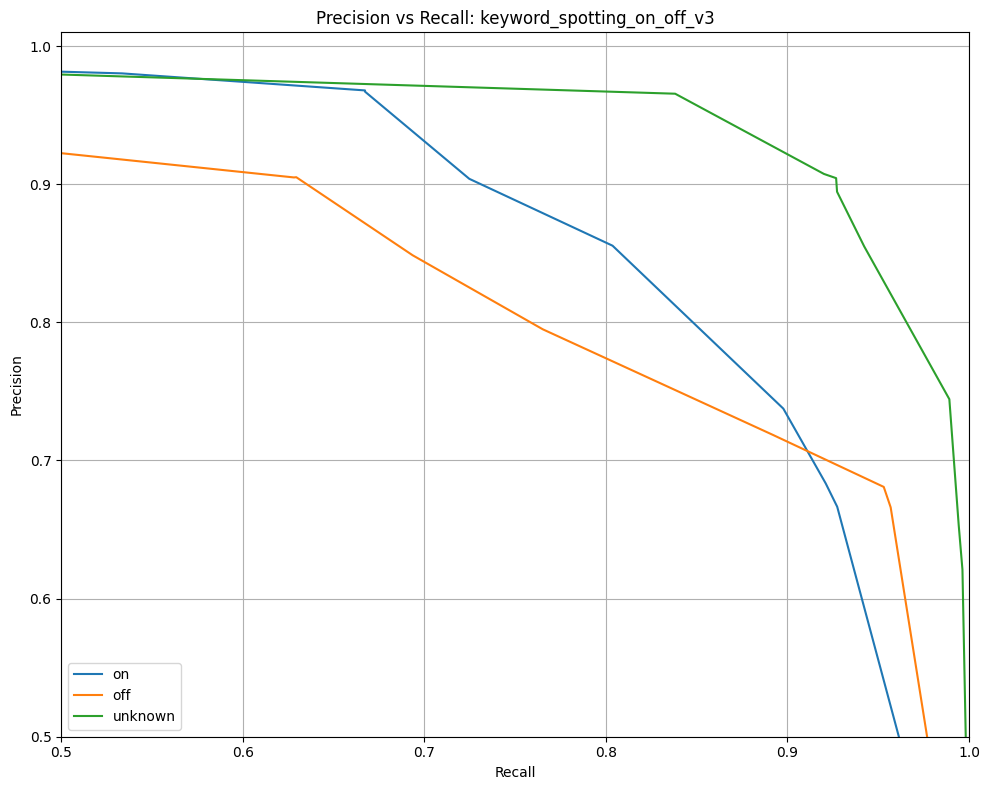

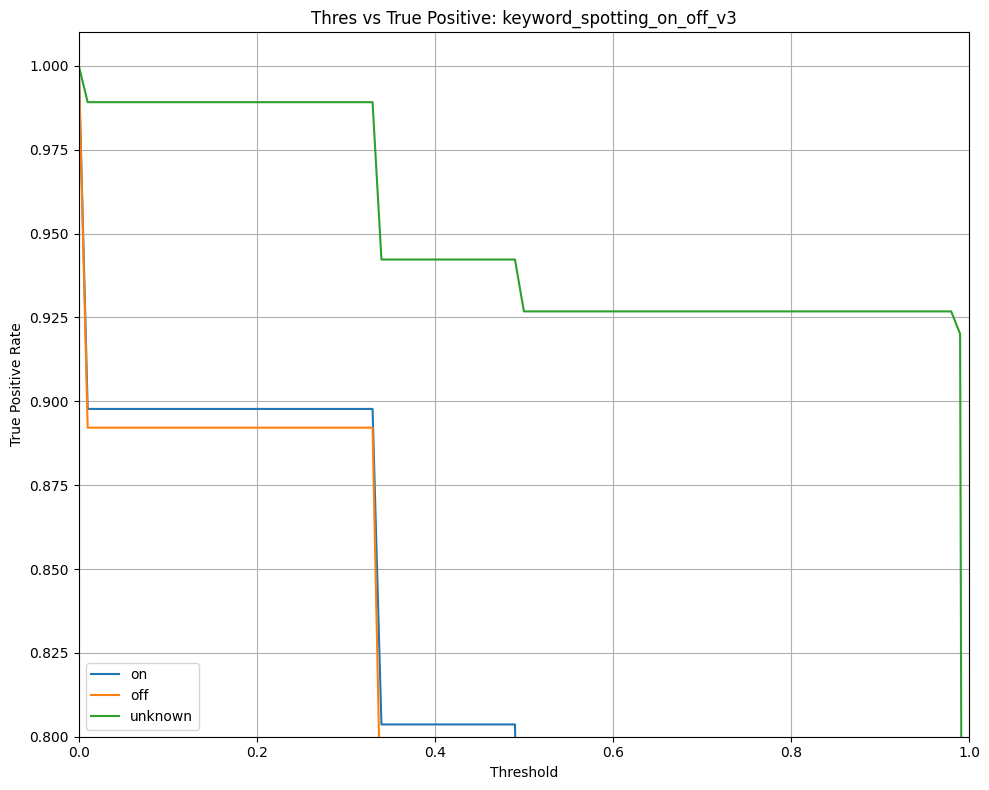

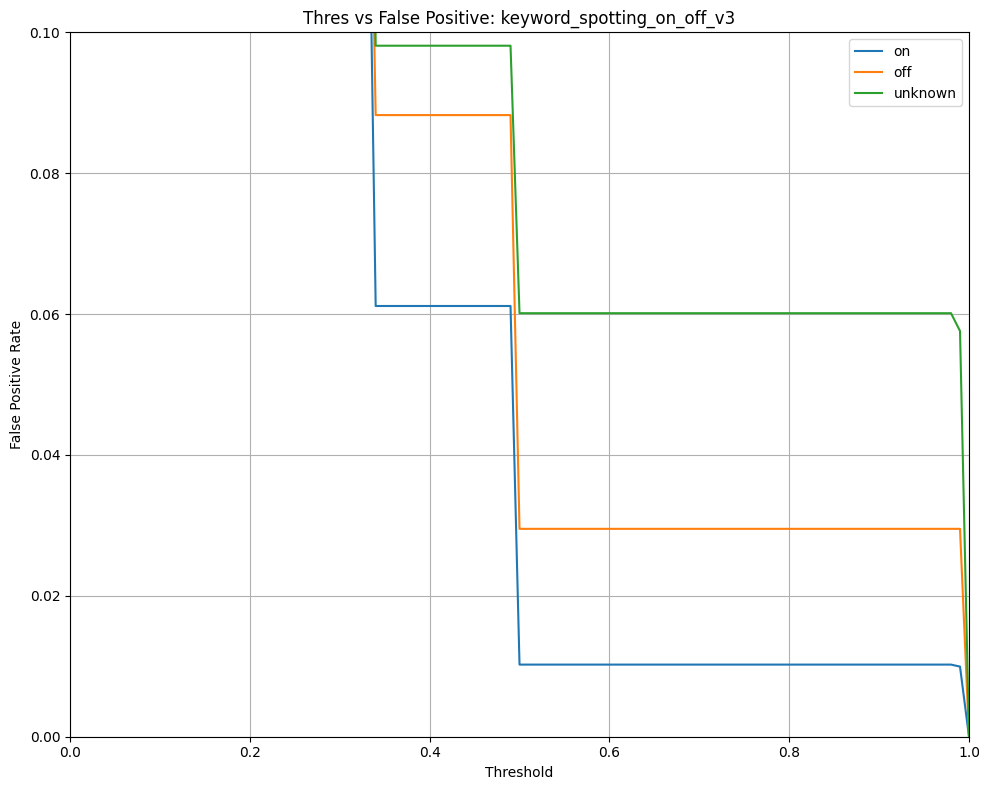

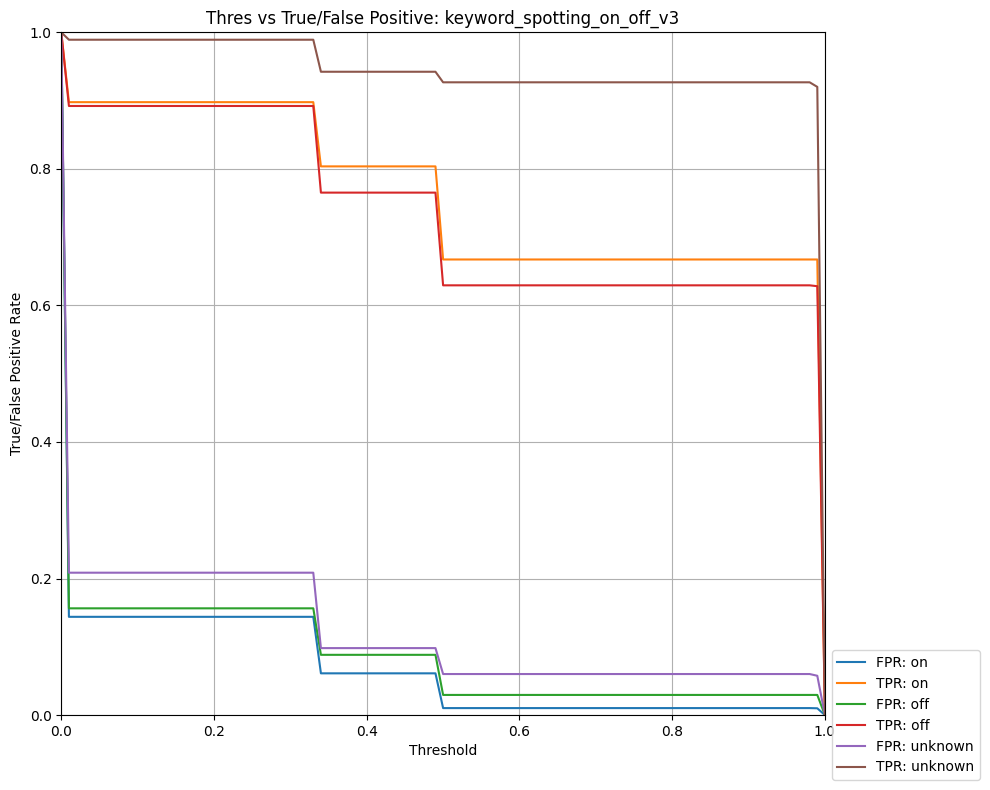

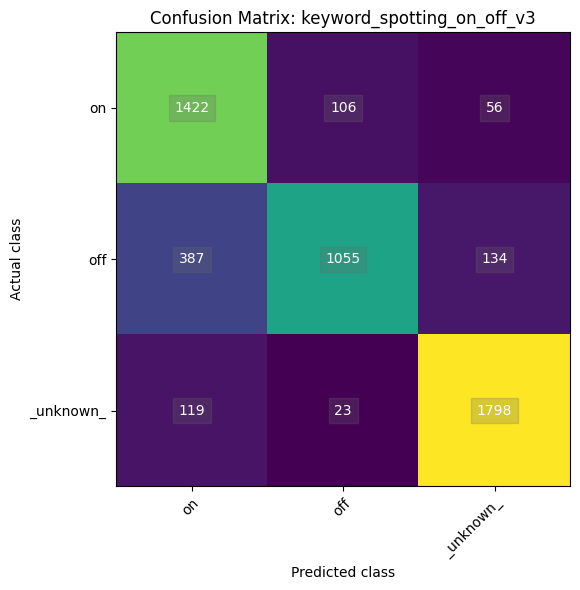

Updating c:/users/dried/silabs/mltk/mltk/models/siliconlabs/keyword_spotting_on_off_v3.mltk.zip
Name: keyword_spotting_on_off_v3
Model Type: classification
Overall accuracy: 83.824%
Class accuracies:
- _unknown_ = 92.680%
- on = 89.773%
- off = 66.942%
Average ROC AUC: 92.888%
Class ROC AUC:
- _unknown_ = 95.815%
- on = 92.367%
- off = 90.481%



In [15]:
# For documentation purposes, we use the evaluate_model Python API so
# the evaluation plots are generated inline with the docs
from mltk.core import evaluate_model 
evaluation_results = evaluate_model('keyword_spotting_on_off_v3', tflite=True, show=True)
print(f'{evaluation_results}')

So in this case, our model has a 83.8% overall accuracy.  

Once again, please refer to the [Model Evaluation Guide](https://siliconlabs.github.io/mltk/docs/guides/model_evaluation.html) for more details about the various metrics generated by this command.

### Note about model accuracy

While model accuracy is highly application-specific, an 84% accuracy of a two-keyword classification model is considered good, not great.
Typically, model accuracy should be in the 92%-97+% range for it to perform well in the field.

The following are things to keep in mind to improve the model accuracy:  
- __Verify the dataset__ - Ensure all the samples are properly labeled and in a consistent format
- __Improve the feature engineering__ - Give the model the best chance to learn the patterns within the data by "amplifying" the signal (e.g. Improve the spectrogram quality)
- __Increase the model size__ - Increase the model size by adding more or wider layers (e.g. add more Conv2D filers)


## Model Testing

__NOTE:__ This section is __experimental__ and is optional for the rest of this tutorial.
You may safely skip to the next section.

During model evaluation, static audio samples are sent through the model to make predictions and determine its accuracy. While this is useful to obtain a consistent, baseline metric of model performance, this setup does not reflect the real-world application of the model.  
In most real world applications, real-time audio is constantly streaming into the model. In this case, the same audio sample will pass multiple times through the model shifted in time each pass (see the [Keyword Spotting Overview](#machine-learning-and-keyword-spotting-overview) section above for more details.) 

To help evaluate this scenario, the MLTK offers the command: `classify_audio`. With this command, the trained model can be used to classify keywords detected in streaming audio from a microphone. The `classify_audio` command features:  
- Support for executing a model on PC or embedded device
- Support for dumping the spectrograms generated by the [AudioFeatureGenerator](https://siliconlabs.github.io/mltk/docs/python_api/data_preprocessing/audio_feature_generator.html)
- Support for recording audio
- Support for adjusting the detection threshold
- Support for viewing the model prediction results in real-time

__NOTE:__ The `classify_audio` command must run locally. It will not work remotely (e.g. on Colab or remote SSH)

See the output of the command help for more details:

In [16]:
!mltk classify_audio --help

                                                                               
 Usage: mltk classify_audio [OPTIONS] <model>                                  
                                                                               
 Classify keywords/events detected in a microphone's streaming audio           
 NOTE: This command is experimental. Use at your own risk!                     
 This command runs an audio classification application on either the local PC  
 OR                                                                            
 on an embedded target. The audio classification application loads the given   
 audio classification ML model (e.g. Keyword Spotting) and streams real-time   
 audio                                                                         
 from the local PC's/embedded target's microphone into the ML model.           
                                                                               
 System Dataflow:                       

### Classify audio on PC

Issue the following command to use your local PC's microphone to stream real-time audio in our trained model:

__NOTE:__ Be sure to replace `keyword_spotting_on_off` with your __trained__ model's name.

In [ ]:
# Run the audio classification application
# Saying the keywords "on" or "off" into your PC's microphone should cause the model to detect them.
# HINT: Add the --verbose flag to view more info from the classification app
# NOTE: This command must be run from a local terminal
!mltk classify_audio keyword_spotting_on_off_v3

### Classify audio on device

Alternatively, we can run the audio classification application + model on a supported embedded device.  
In this case, we use the embedded device's microphone and the trained model executes on the embedded device.

To run on an embedded device, add the `--device` flag.
When a keyword is detected an LED will turn on and a log will be printed to the console.

__NOTE:__ A supported embedded device must be locally connected to run the command.

#### Note about DSP

Currently, __your mouth must be ~2 inches from the board's microphone__ for it to reliably detect keywords.  
This is because the board microphone's lack advanced Digital Signal Processing (DSP) features like [Beamforming](https://en.wikipedia.org/wiki/Beamforming).
A future release of the Gecko SDK will offer this feature to improve audio quality from longer distances.

In [ ]:
# Run the audio classification application with MVP acceleration
# Remove the "--accelerator MVP" if your device does not support the MVP.
# Saying the keywords "on" or "off" into device's microphone should cause the model to detect them
# which will cause the LED to turn on and a message to be printed to the console.
# HINT: Add the --verbose flag to view more info from the classification app
# NOTE: This command must run from a local terminal
# NOTE: Your mouth must be ~2 inches from the board's microphone
!mltk classify_audio keyword_spotting_on_off_v3 --device --accelerator MVP

### Record audio and spectrograms from device

Another useful feature of the `classify_audio` command is the ability to record audio and spectrograms from the embedded device.  
This is done by adding the `--dump-audio` or `--dump-spectrograms` flags to the command.  
When the command completes, a log directory will contain the dumped audio sound file (.wav) or dumped spectrogram images (.jpg)

In [ ]:
# Dump audio from an embedded device's microphone
# The dumped audio will be found in the log directory:
# ~/.mltk/audio_classify_recordings/<platform>/audio
# NOTE: This command must run from a local terminal
!mltk classify_audio keyword_spotting_on_off_v3 --device --dump-audio

In [ ]:
# Dump audio from an embedded device's microphone
# The dumped audio will be found in the log directory:
# ~/.mltk/audio_classify_recordings/<platform>/spectrograms
# NOTE: This command must run from a local terminal
!mltk classify_audio keyword_spotting_on_off_v3 --device --dump-spectrograms

## Deploying the Model

Now that we have a trained model, it is time to run it in on an embedded device.

There are several different ways this can be done:

### Using Simplicity Studio

The standard Gecko SDK also features an [audio_classifier](https://github.com/SiliconLabs/gecko_sdk/tree/gsdk_4.0/app/common/example/audio_classifier) application.

The basic sequence for updating the app with a new model is:  
1. Using [Simplicity Studio](https://www.silabs.com/developers/simplicity-studio) create a new "Audio Classifier" project
2. Extract the `.tflite` model file from the MLTK [Model Archive](https://siliconlabs.github.io/mltk/docs/guides/model_archive.html)
3. Copy the `.tflite` model file to a Gecko SDK project in Simplicity Studio, more details [here](https://docs.silabs.com/gecko-platform/latest/machine-learning/tensorflow/getting-started)
4. Build the Gecko SDK project via Simplicity Studio
5. Program the built firmware image to the embedded device
6. Run the firmware image with trained model on the embedded device

When Simplicity Studio builds the project, it finds the `.tflite` model file and generates a C header file which contains a C `uint8_t` array of the binary data in the `.tflite`. The firmware then references the C array and loads it into the [Tensorflow-Lite Micro Interpreter](https://github.com/tensorflow/tflite-micro).

See the [Getting Started with Machine Learning](https://docs.silabs.com/gecko-platform/latest/machine-learning/tensorflow/getting-started) Gecko SDK guide for more details.


### Using the MLTK

The MLTK supports building [C++ Applications](https://siliconlabs.github.io/mltk/docs/cpp_development/index.html).

It also features an [audio_classifier](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/audio_classifier.html) C++ application
which can be built using:  
- [Visual Studio Code](https://siliconlabs.github.io/mltk/docs/cpp_development/vscode.html) 
- [Simplicity Studio](https://siliconlabs.github.io/mltk/docs/cpp_development/simplicity_studio.html)
- [Command Line](https://siliconlabs.github.io/mltk/docs/cpp_development/command_line.html)

Refer to the [audio_classifier](https://siliconlabs.github.io/mltk/docs/cpp_development/examples/audio_classifier.html) application's documentation
for how include your model into the built application.
